# ANNDL TimeSeriesForecasting Challenge - Polimi 2021-2022

## Notebook Settings

### Import Libraries


In [1]:
import tensorflow as tf
import numpy as np
import io
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import scipy.io as sio

from plotly.subplots import make_subplots
import plotly.graph_objects as go

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Seed or Reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Load Dataset


In [3]:
dataset = pd.read_csv('../input/training/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
dataset.columns = [c.replace(' ', '_') for c in dataset.columns]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder_level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness_on_impact  68528 non-null  float64
 4   Meme_creativity     68528 non-null  float64
 5   Soap_slipperiness   68528 non-null  float64
 6   Hype_root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


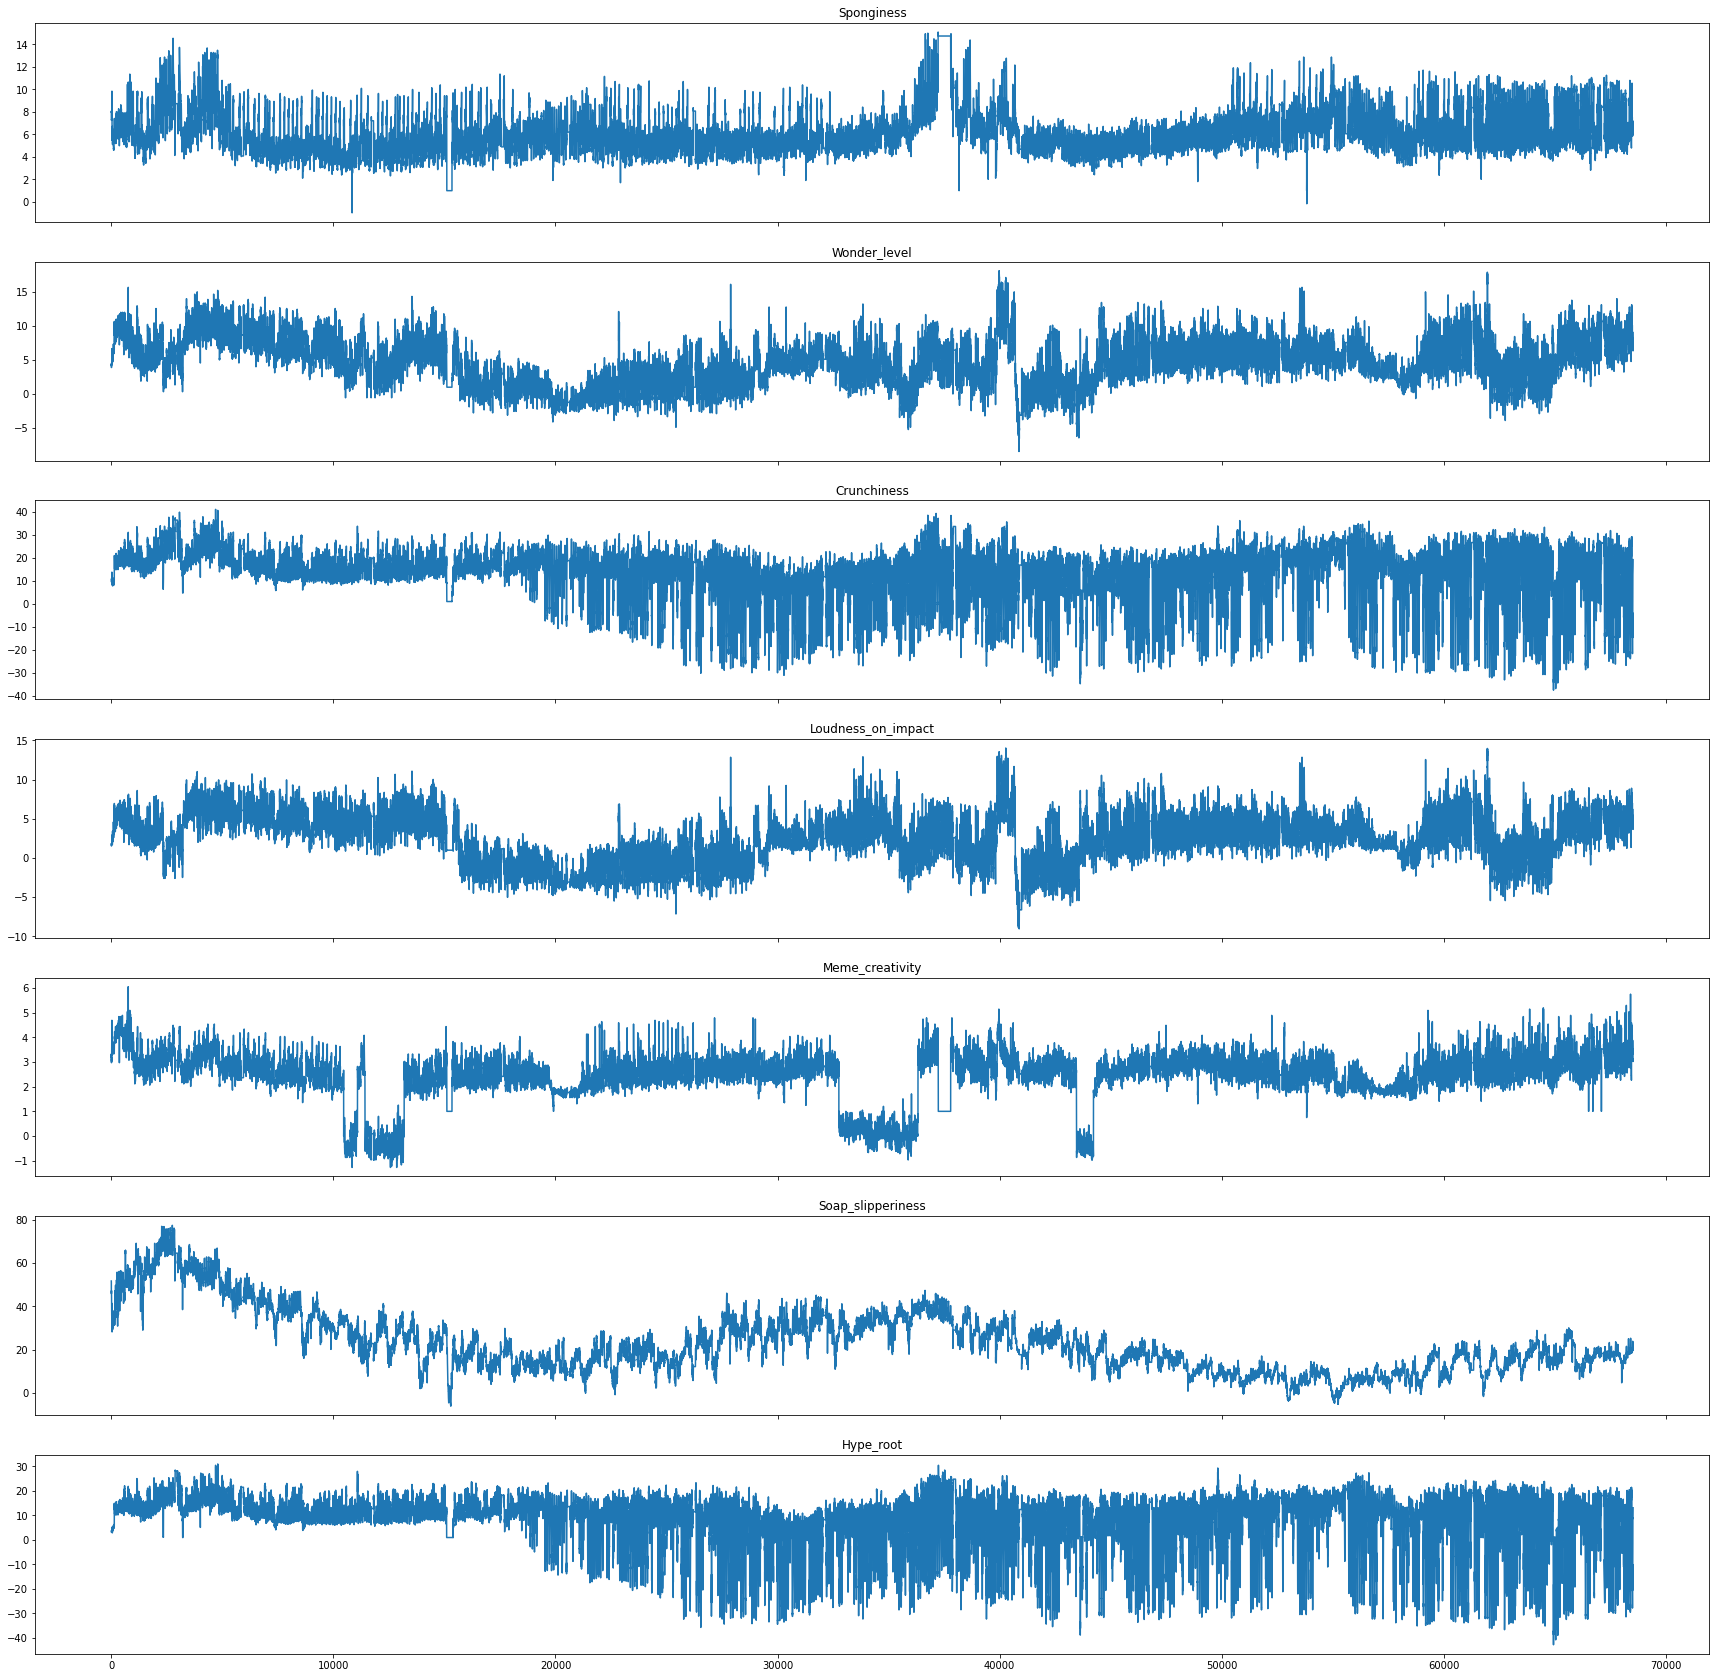

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,30))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
inspect_dataframe(dataset, dataset.columns)

(66528, 7) (2000, 7)


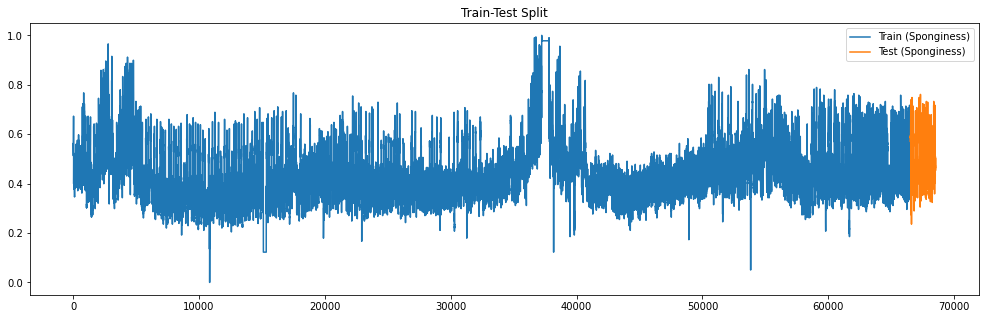

In [6]:
test_size = 2000
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

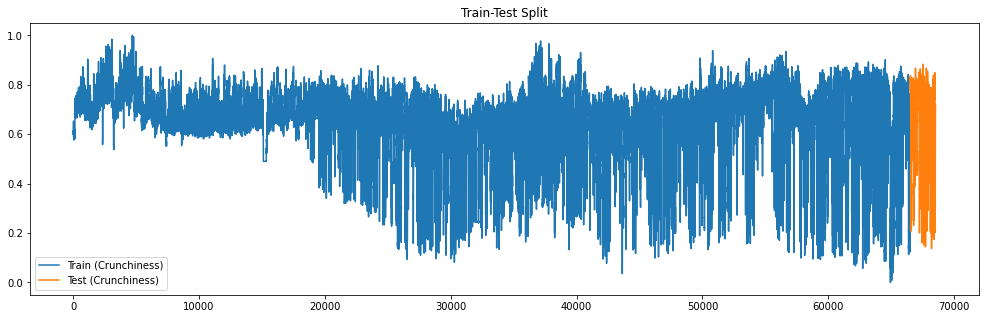

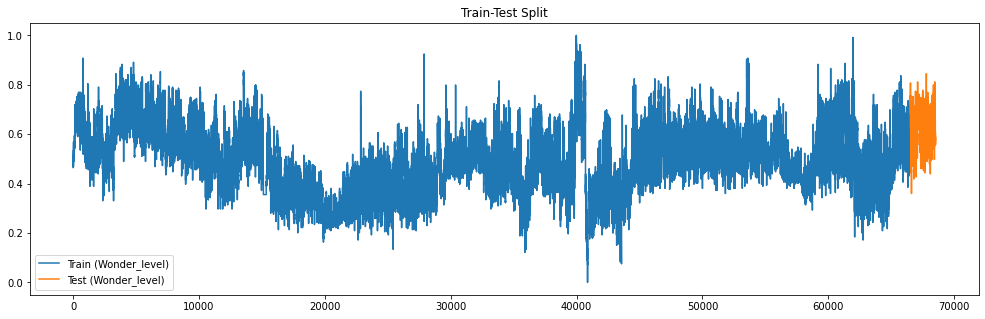

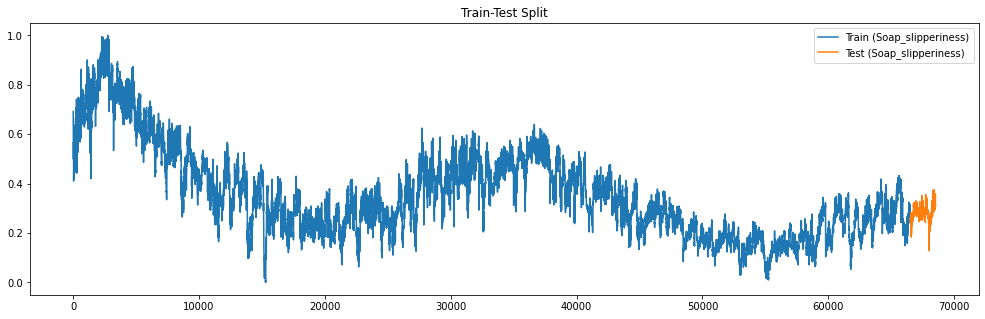

In [7]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Wonder_level, label='Train (Wonder_level)')
plt.plot(X_test_raw.Wonder_level, label='Test (Wonder_level)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Soap_slipperiness, label='Train (Soap_slipperiness)')
plt.plot(X_test_raw.Soap_slipperiness, label='Test (Soap_slipperiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [8]:
window = 1500
stride = 10

In [9]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 1500, 7)

In [10]:
target_labels = dataset.columns
telescope = 144

In [11]:
def build_sequences(df, target_labels, window=window, stride=stride, telescope=telescope):
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [12]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6586, 1500, 7), (6586, 144, 7), (136, 1500, 7), (136, 144, 7))

In [13]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [14]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

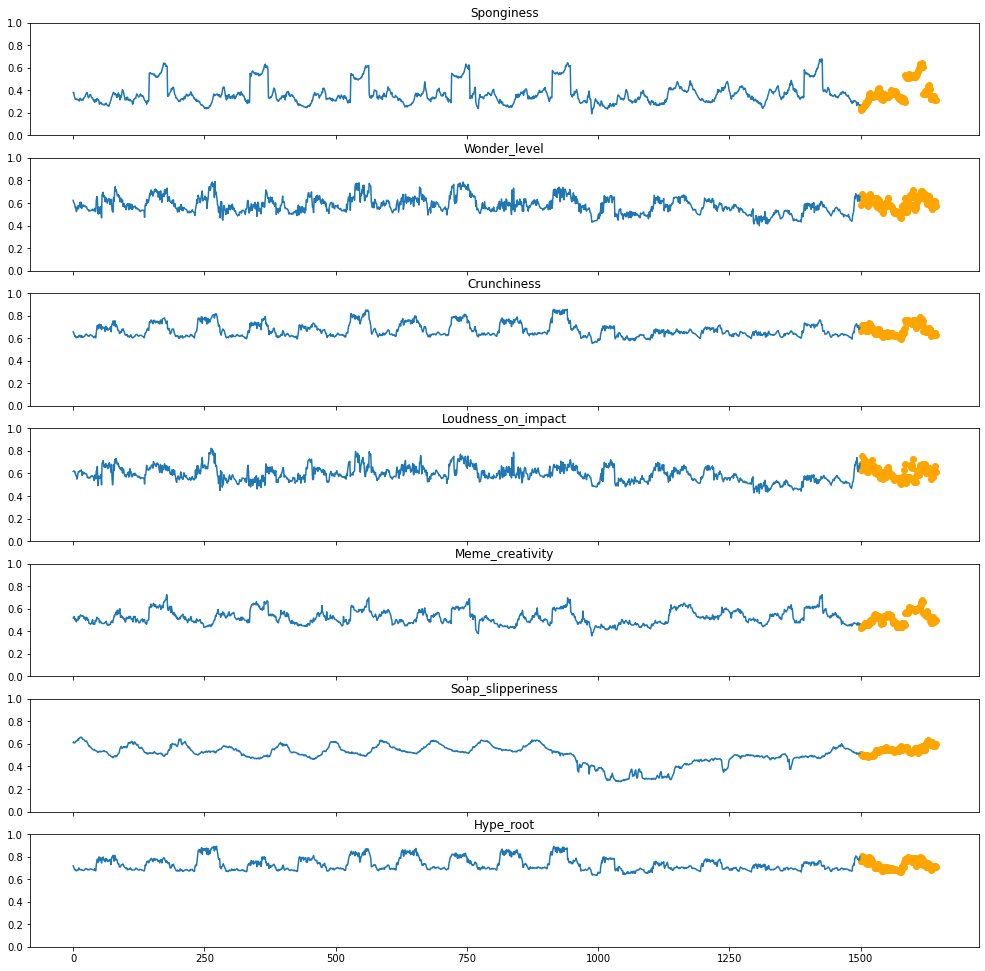

In [15]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

## Model

In [16]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [17]:
# Function to create the model 
def sequence2sequence():
    # Build Encoder-Decoder Model

    # ENCODER
    encoder_input = tfk.Input(shape=input_shape, name='encoder_input')
    
    encoder_1 = tfkl.LSTM(units=256, return_state=True, return_sequences=True, name='encoder_lstm_1')(encoder_input)
    
    encoder_output = tfkl.LSTM(units=256, return_state=True, name='encoder_lstm')(encoder_1)


    # Save encoder state (to initialize the decoder)
    encoder_state = encoder_output[1:]

    # DECODER
    decoder_inputs = tfkl.RepeatVector(telescope)(encoder_output[0])
                 
    decoder_lstm_1 = tfkl.LSTM(units=256, return_sequences=True, return_state=True, 
                                              name='decoder_lstm_1')(decoder_inputs, initial_state=encoder_state)


    decoder_lstm, _, _, *_ = tfkl.LSTM(units=256, return_sequences=True, return_state=True, 
                                              name='decoder_lstm')(decoder_lstm_1)


    decoder_out = tfkl.TimeDistributed(tfkl.Dense(output_shape[-1]))(decoder_lstm)

    # MODEL
    model = tf.keras.Model(encoder_input,  decoder_out) #decoder_inputs],

    # ----------
    # Compile training model
    model.compile(loss=tfk.losses.MeanSquaredError(),
                  optimizer=tfk.optimizers.Adam(4*1e-4), metrics=['mae']) 
    
    return model, encoder_state

In [18]:
seq2seq_model, encoder_state = sequence2sequence()

seq2seq_model.summary()

2022-01-15 15:10:55.149977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 15:10:55.320263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 15:10:55.321042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 15:10:55.322251: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 1500, 7)]    0                                            
__________________________________________________________________________________________________
encoder_lstm_1 (LSTM)           [(None, 1500, 256),  270336      encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 525312      encoder_lstm_1[0][0]             
                                                                 encoder_lstm_1[0][1]             
                                                                 encoder_lstm_1[0][2]             
______________________________________________________________________________________________

In [19]:
history = seq2seq_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_mae', mode='min', patience=5, factor=0.5, min_lr=1e-5),
    ]
    
).history

2022-01-15 15:10:59.565993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-15 15:11:04.910623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 37s 321ms/step - loss: 0.0255 - mae: 0.1111 - val_loss: 0.0195 - val_mae: 0.0980
Epoch 2/200
93/93 [==============================] - 29s 309ms/step - loss: 0.0107 - mae: 0.0737 - val_loss: 0.0184 - val_mae: 0.0949
Epoch 3/200
93/93 [==============================] - 29s 310ms/step - loss: 0.0102 - mae: 0.0715 - val_loss: 0.0180 - val_mae: 0.0952
Epoch 4/200
93/93 [==============================] - 29s 310ms/step - loss: 0.0098 - mae: 0.0701 - val_loss: 0.0175 - val_mae: 0.0931
Epoch 5/200
93/93 [==============================] - 29s 309ms/step - loss: 0.0096 - mae: 0.0695 - val_loss: 0.0179 - val_mae: 0.0971
Epoch 6/200
93/93 [==============================] - 29s 309ms/step - loss: 0.0094 - mae: 0.0691 - val_loss: 0.0166 - val_mae: 0.0923
Epoch 7/200
93/93 [==============================] - 29s 309ms/step - loss: 0.0093 - mae: 0.0687 - val_loss: 0.0168 - val_mae: 0.0900
Epoch 8/200
93/93 [==============================] - 29s 309ms/step - loss

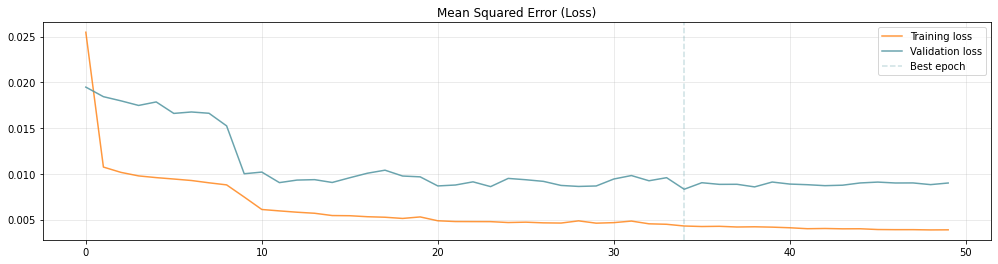

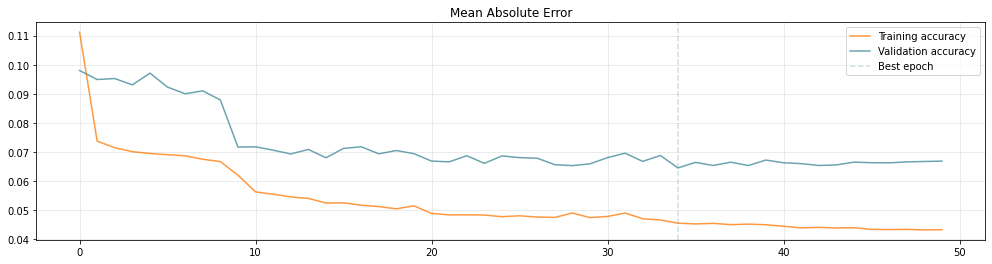

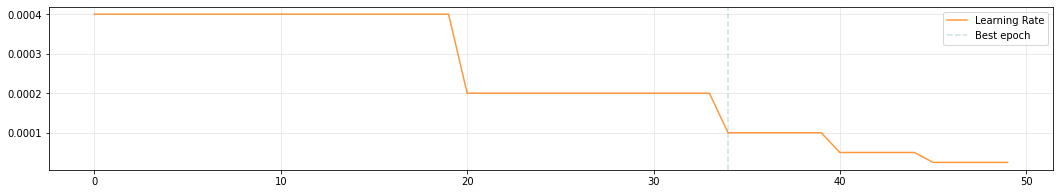

In [20]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [21]:

seq2seq_model.save('Seq2Seq')
import shutil
saved_model = "./Seq2Seq"
shutil.make_archive("Seq2Seq", 'zip', saved_model)

2022-01-15 15:35:35.709551: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


'/kaggle/working/Seq2Seq.zip'

In [22]:
# Predict the test set 
predictions = seq2seq_model.predict(X_test)
print(predictions.shape)

(136, 144, 7)


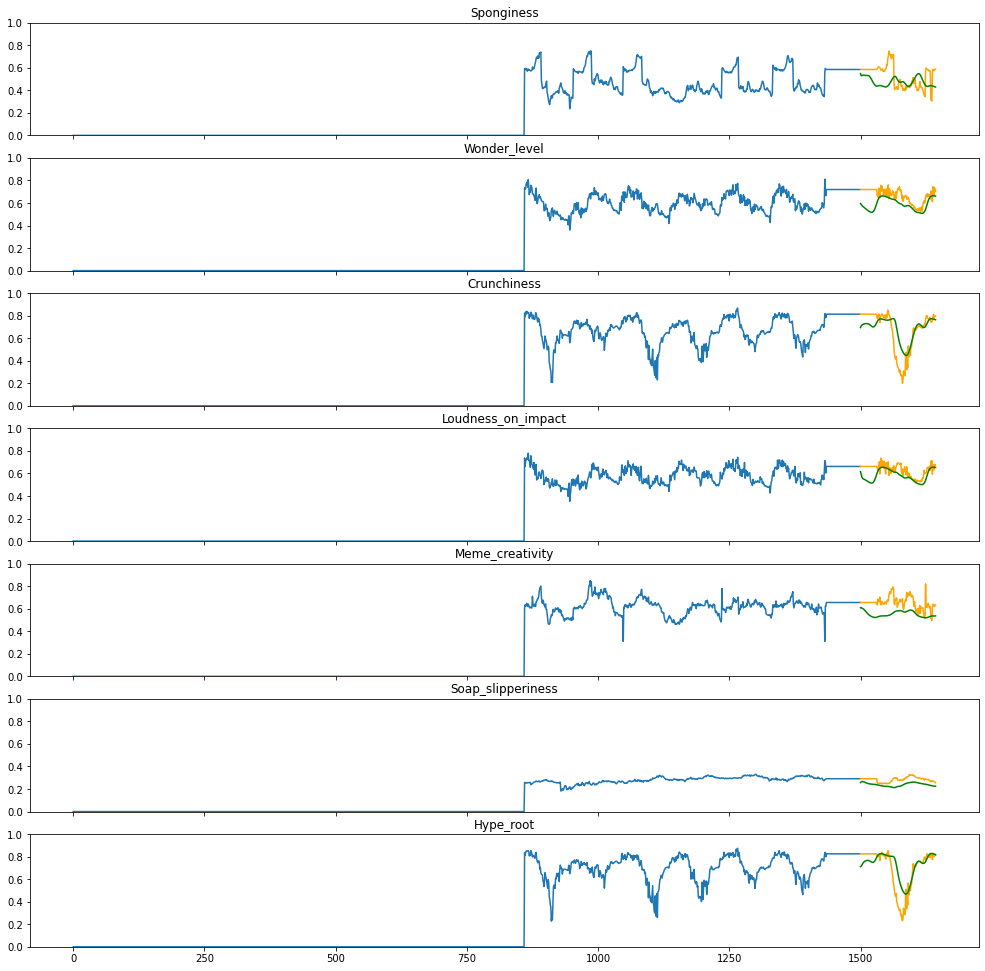

In [23]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

## Autoregressive Forecasting


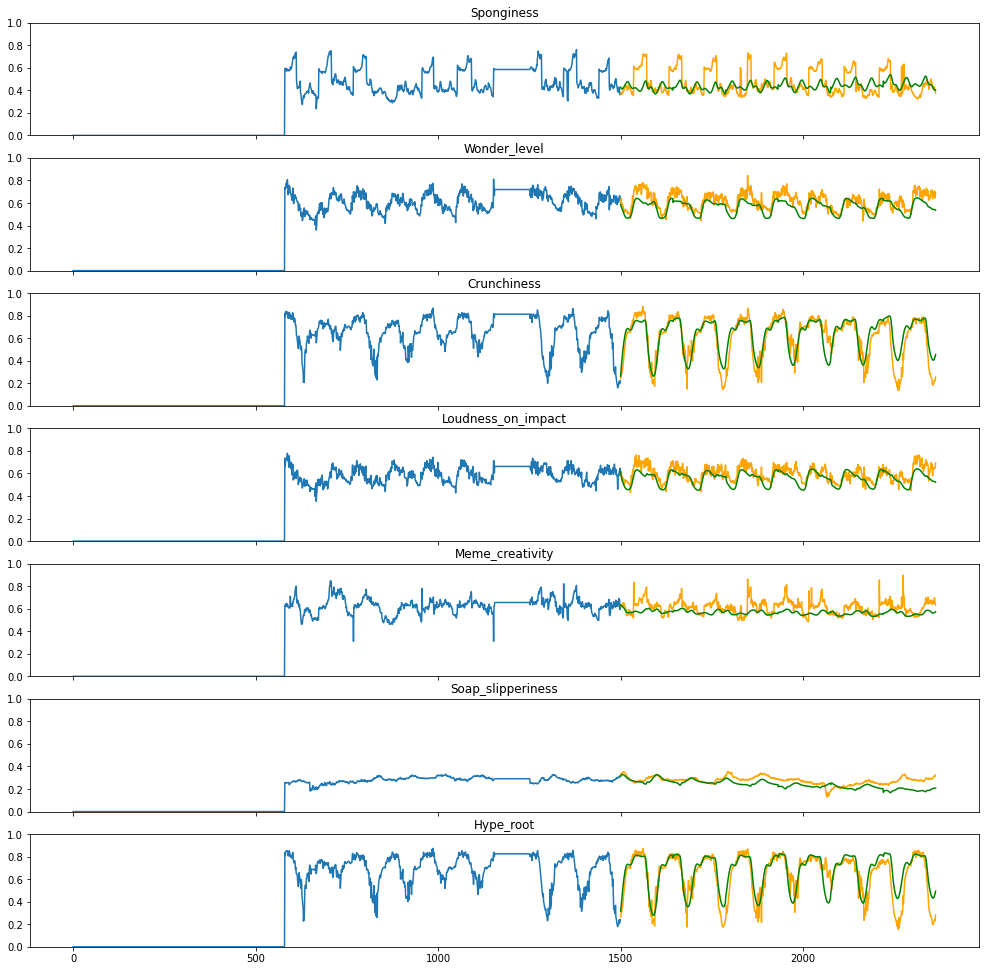

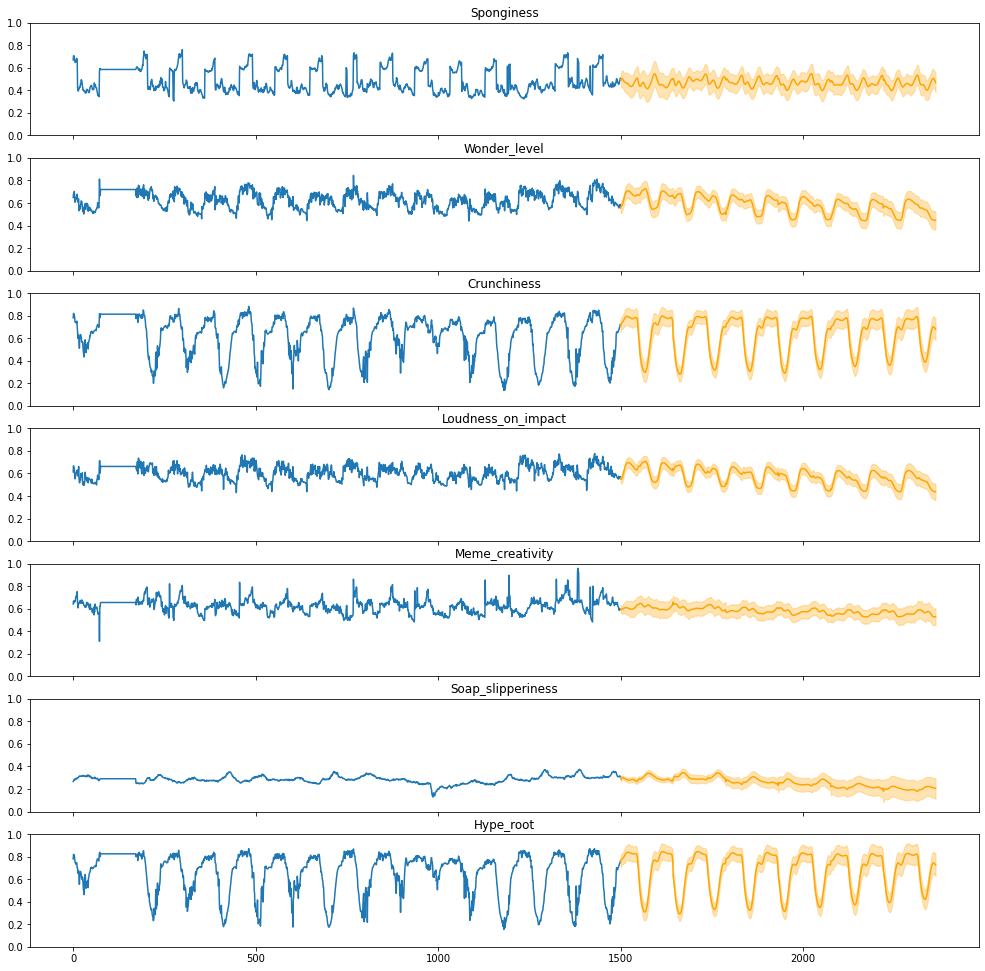

In [24]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

#Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = seq2seq_model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

reg_predictions.shape

mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

maes = []
for i in range(reg_predictions.shape[1]): 
    ft_maes = []
    for j in range(reg_predictions.shape[2]): 
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0)) 
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

reg_future = np.array([])
X_temp = future
X_temp.shape

for reg in range(0,reg_telescope,telescope):
    pred_temp = seq2seq_model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()